# Investigating RNNs and RL using the N-back cognitive task

**NMA 2023 Group 1 Project**

__Content creators:__ Alan Astudilo, Campbell Border, Disheng, Julia Yin, Koffivi

__Pod TA:__ Suryanarayanan Nagar Anthel Venkatesh

__Project Mentor:__ 

---
# Objective

- 

- 
---

# Project Design
---

# Setup

## Install Dependencies

In [2]:
# @title Install dependencies
%pip install jedi --quiet
%pip install --upgrade pip setuptools wheel --quiet
%pip install numpy==1.23.3 --quiet --ignore-installed
%pip install gymnasium --quiet
%pip install torch --quiet

%pip install matplotlib --quiet
%pip uninstall seaborn -y --quiet
%pip install seaborn --quiet

#!pip install trfl --quiet


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# @title Imports

import numpy as np
from numpy.random import default_rng
import gymnasium as gym
from gymnasium import spaces
import torch
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns

## Figure settings

In [4]:
# @title Figure settings
from IPython.display import clear_output, display, HTML
%matplotlib inline
sns.set()

---
# Background

## Replace with our own literature review

- Cognitive scientists use standard lab tests to tap into specific processes in the brain and behavior. Some examples of those tests are Stroop, N-back, Digit Span, TMT (Trail making tests), and WCST (Wisconsin Card Sorting Tests).

- Despite an extensive body of research that explains human performance using descriptive what-models, we still need a more sophisticated approach to gain a better understanding of the underlying processes (i.e., a how-model).

- Interestingly, many of such tests can be thought of as a continuous stream of stimuli and corresponding actions, that is in consonant with the RL formulation. In fact, RL itself is in part motivated by how the brain enables goal-directed behaviors using reward systems, making it a good choice to explain human performance.

- One behavioral test example would be the N-back task.

  - In the N-back, participants view a sequence of stimuli, one by one, and are asked to categorize each stimulus as being either match or non-match. Stimuli are usually numbers, and feedback is given at both timestep and trajectory levels.

  - The agent is rewarded when its response matches the stimulus that was shown N steps back in the episode. A simpler version of the N-back uses two-choice action schema, that is match vs non-match. Once the present stimulus matches the one presented N step back, then the agent is expected to respond to it as being a `match`.


- Given a trained RL agent, we then find correlates of its fitted parameters with the brain mechanisms. The most straightforward composition could be the correlation of model parameters with the brain activities.

## Datasets

- HCP WM task ([NMA-CN HCP notebooks](https://github.com/NeuromatchAcademy/course-content/tree/master/projects/fMRI))

Any dataset that used cognitive tests would work.
Question: limit to behavioral data vs fMRI?
Question: Which stimuli and actions to use?
classic tests can be modeled using 1) bounded symbolic stimuli/actions (e.g., A, B, C), but more sophisticated one would require texts or images (e.g., face vs neutral images in social stroop dataset)
The HCP dataset from NMA-CN contains behavioral and imaging data for 7 cognitive tests including various versions of N-back.

### We need to copy the data and see what's happening

## N-back task

In the N-back task, participants view a sequence of stimuli, one per time, and are asked to categorize each stimulus as being either match or non-match. Stimuli are usually numbers, and feedbacks are given at both timestep and trajectory levels.

In a typical neuro setup, both accuracy and response time are measured, but here, for the sake of brevity, we focus only on accuracy of responses.

---
## Implementation scheme

### Environment
The following cell implments N-back envinronment, that we later use to train a RL agent on human data.

In [62]:
# N-back environment
class NBack(gym.Env):

    # Examples
    # N = 2
    # step_count =        [ 0  1  2  3  4  5  6 ]
    # sequence =          [ a  b  c  d  a  d  a ] (except these are usually digits between 0-9)
    # correct actions =   [ ~  ~  0  0  0  1  1 ]

    # actions =           [ ~  ~   1     0      0  1  0 ]
                      #           80 20 30 70 
    # reward_class =      [ ~  ~  FP TN TN TP FN]
    # reward =            [ ~  ~  -1  0  0  1 -1]

  # Rewards input is structured as (TP, TN, FP, FN) (positive being matches)
  def __init__(self, N=2, num_trials=25, num_targets=None, rewards=(1, 1, -1, -1), obs_length=1, seed=2023):

    self.N = N
    self.num_trials = num_trials
    self.episode_length = num_trials + self.N
    self.num_targets = num_targets
    self.rewards = rewards
    self.obs_length = obs_length
    super().reset(seed=seed)

    # Check that parameters are legal
    assert(len(rewards) == 4)
    assert(num_targets is None or num_targets <= num_trials)

    # Define rewards, observation space and action space 
    self.reward_range = (min(rewards), max(rewards))  # Range of rewards based on inputs
    self.observation_space = spaces.Discrete(10)      # Single variable with 10 possibilities if using digits or 26 if using letters
    self.action_space = spaces.Discrete(2)            # 0 (No match) or 1 (Match)

  def reset(self, seed=None):

    # Seed RNG
    super().reset(seed=seed)

    # Generate sequence and correct actions
    self._generate_sequence()
    self._get_correct_actions()

    # Observation is first character
    self.step_count = 0
    observation = self._get_observation()
    

    return observation, self.step_count, None, False

  def step(self, action):

    # Calculate reward
    if self.step_count >= self.N:
      if (self.correct_actions[self.step_count - self.N]): # Match
        reward = self.rewards[0] if action else self.rewards[3] # TP if matched else FN
      else: # No match
        reward = self.rewards[2] if action else self.rewards[1] # FP if matches else TN
    else:
      reward = None

    # Return next character or None
    self.step_count += 1
    if self.step_count < self.episode_length:
      return self._get_observation(), self.step_count, reward, False
    else:
      return None, self.step_count, reward, True

  def _generate_sequence(self):

    # Generate sequence of length self.episode_length (with correct number of targets)
    while True:

      self.sequence = np.random.randint(0, 9, size=(self.episode_length))
      if not self.num_targets or sum(self._get_correct_actions()) == self.num_targets:
        break

  def _get_observation(self):

    if self.step_count < self.obs_length:
      observation = np.concatenate((np.zeros(self.obs_length - self.step_count - 1, dtype=int), self.sequence[:self.step_count + 1]))
    else:
      observation = self.sequence[self.step_count + 1 - self.obs_length : self.step_count + 1]

    return observation
      
  def _get_correct_actions(self):
    self.correct_actions = np.array([int(self.sequence[i] == self.sequence[i + self.N]) for i in range(self.num_trials)])
    return self.correct_actions

In [92]:
# Test environment

env = NBack(N=2, num_trials=10, obs_length=1)
obs, _, _, done = env.reset()
print(env.sequence)
print(env.step_count, obs)
while not done:
  obs, _, _, done = env.step(0)

  print(env.step_count, obs)

[6 8 8 8 5 4 4 3 7 7 5 7]
0 [6]
1 [8]
2 [8]
3 [8]
4 [5]
5 [4]
6 [4]
7 [3]
8 [7]
9 [7]
10 [5]
11 [7]
12 None


### Define a random agent

In [94]:
# Random agent
class RandomAgent(nn.Module):
    
    def __init__(self, env):
        super().__init__()
        self.env = env

    # Choose a random action, 0 or 1
    def choose_action(self, seq):
        return np.random.randint(0, 2)

    def test(self, num_episodes):
        
        # Arrays to hold true/false positives and false negatives
        tps = np.zeros(num_episodes)
        fps = np.zeros_like(tps)
        fns = np.zeros_like(tps)

        for i in range(num_episodes):
            
            # Array of actions
            actions = np.zeros(self.env.episode_length, dtype=int)

            # Perform action for each element in sequence
            seq, step_count, _, done = self.env.reset()
            while not done:
                action = self.choose_action(seq)
                actions[step_count] = action
                seq, step_count, _, done = self.env.step(action)
            
            # Get episode data
            actions = actions[self.env.N:]
            correct_actions = self.env.correct_actions
            tps[i] = np.dot(actions, correct_actions) 
            fps[i] = np.dot(actions, 1 - correct_actions)
            fns[i] = np.dot(1 - actions, correct_actions)

        return tps, fps, fns

[2]
[2]
[0]
[1]
[8]
[7]
[1]
[4]
[3]
[7]
[1]
[8]
[1]
[6]
[1]
[5]
[4]
[6]
[5]
[8]
[1]
[3]
[5]
[3]
[1]
[2]
[4]
[4]
[8]
[2]
[7]
[1]
[0]
[7]
[6]
[5]
[6]
[8]
[4]
[8]
[8]
[8]
[0]
[7]
[0]
[4]
[1]
[8]
[1]
[5]
[4]
[0]
[3]
[7]
[0]
[6]
[0]
[8]
[8]
[0]
[3]
[6]
[1]
[4]
[6]
[7]
[8]
[2]
[4]
[4]
[8]
[0]
[3]
[6]
[1]
[8]
[4]
[2]
[1]
[4]
[3]
[3]
[6]
[7]
[0]
[3]
[4]
[4]
[8]
[8]
[5]
[1]
[2]
[3]
[5]
[2]
[8]
[2]
[6]
[7]
[0]
[8]
[3]
[2]
[8]
[1]
[4]
[6]
[3]
[0]
[1]
[2]
[6]
[1]
[7]
[2]
[5]
[1]
[0]
[2]
[8]
[0]
[3]
[6]
[5]
[4]
[1]
[6]
[2]
[7]
[5]
[5]
[1]
[7]
[2]
[0]
[5]
[8]
[0]
[4]
[3]
[8]
[8]
[8]
[3]
[8]
[0]
[4]
[8]
[4]
[8]
[0]
[0]
[6]
[0]
[4]
[4]
[5]
[3]
[6]
[5]
[6]
[1]
[6]
[7]
[8]
[7]
[1]
[8]
[8]
[5]
[6]
[0]
[2]
[6]
[1]
[8]
[5]
[8]
[4]
[3]
[1]
[0]
[6]
[7]
[5]
[1]
[7]
[4]
[3]
[5]
[4]
[6]
[8]
[6]
[1]
[1]
[4]
[8]
[5]
[0]
[4]
[0]
[5]
[1]
[6]
[6]
[6]
[7]
[0]
[6]
[5]
[7]
[6]
[7]
[5]
[4]
[3]
[8]
[4]
[3]
[2]
[5]
[7]
[8]
[7]
[7]
[3]
[4]
[6]
[1]
[5]
[4]
[6]
[6]
[1]
[6]
[5]
[2]
[4]
[0]
[3]
[3]
[3]
[8]
[8]
[0]
[7]
[0]
[6]


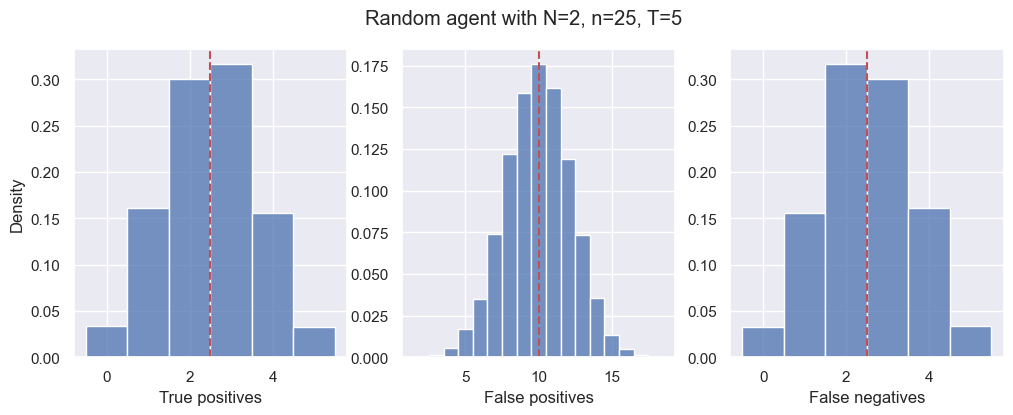

In [95]:
# @title Test random agent
# Create environment, random agent and test
N = 2
n = 25
T = 5
env = NBack(N=2, num_trials=n, num_targets=T)
agent = RandomAgent(env=env)
results = agent.test(10000)

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
fig.suptitle(f"Random agent with N={N}, n={n}, T={T}")
sns.histplot(results[0], stat="density", bins=4, discrete=True)
plt.axvline(T/2, color='r', linestyle='--')
plt.xlabel('True positives')

plt.subplot(1, 3, 2)
sns.histplot(results[1], stat="density", bins=17, discrete=True)
plt.axvline((n-T)/2, color='r', linestyle='--')
plt.xlabel('False positives')
plt.ylabel('')

plt.subplot(1, 3, 3)
sns.histplot(results[2], stat="density", bins=4, discrete=True)
plt.axvline(T/2, color='r', linestyle='--')
plt.xlabel('False negatives')
plt.ylabel('')
plt.show()

### Define a simple Q-learning agent

In [151]:
class QLearningMLP(nn.Module):
    
    def __init__(self, env, input_size=1, hidden_sizes=[], actv="ReLU()"):
        super().__init__()

        self.env = env                 
        self.input_size = input_size
        self.output_size = 2
        self.hidden_sizes = hidden_sizes
        self.mlp = nn.Sequential()

        # Create net
        prev_size = self.input_size # Initialize the temporary input feature to each layer
        for i in range(len(hidden_sizes)): # Loop over layers and create each one
            
            # Add linear layer
            current_size = hidden_sizes[i] # Assign the current layer hidden unit from list
            layer = nn.Linear(prev_size, current_size)
            prev_size = current_size # Assign next layer input using current layer output
            self.mlp.add_module('Linear_%d'%i, layer) # Append layer to the model

            # Add activation function
            actv_layer = eval('nn.%s'%actv) # Assign activation function (eval allows us to instantiate object from string)
            self.mlp.add_module('Activation_%d'%i, actv_layer) # Append activation to the model with a name

        out_layer = nn.Linear(prev_size, self.output_size) # Create final layer
        self.mlp.add_module('Output_Linear', out_layer) # Append the final layer

        # Softmax layer
        softmax_layer = nn.Softmax()
        self.mlp.add_module('Output_Softmax', softmax_layer)

    def forward(self, x):

        # Do we need to reshape?
        input = torch.Tensor(x)
        return self.mlp(input)

    def choose_action(self, seq):

        # Run sequence through network
        output = self.forward(seq)
        # Choose highest likelihood action
        return np.argmax(output.detach())


    def train(self, num_episodes):

        for i in range(num_episodes):

            # Array of actions
            actions = np.zeros(self.env.episode_length, dtype=int)

            # Reset environment
            seq, step_count, _, done = self.env.reset()

            while not done:

                # Choose action and recieve reward
                action = self.choose_action(seq)
                print(action)
                actions[step_count] = action
                seq, step_count, reward, done = self.env.step(action)

                # Use reward to update network



In [152]:
# Test QLearningMLP
N = 2
num_trials = 25
memory = 4

env = NBack(N=N, num_trials=num_trials, obs_length=memory)
agent = QLearningMLP(env=env, input_size=memory, hidden_sizes=[64])

agent.train(10)


tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)


/Users/campbellborder/Projects/NMA/NMA-group1/.conda/lib/python3.11/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


### Define a Recurrent Deep Q-learning Agent (RDQN)